<a href="https://colab.research.google.com/github/AmoguJUduka/MachineLearning/blob/main/DeepLearningAssignments/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.0 Overview**:

In this assignment, I experiment with Convolutional Neural Networks (CNNs) using the CIFAR-10 dataset to explore the concepts of underfitting, overfitting, and appropriate model complexity.

For this goal, I compute the number of parameters to be trained in a CNN model. I also compare different CNN architectures and summarize key design ideas.  

**Dataset**:

I used the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

**Tools**: PyTorch

**Using the required CPU**

In [1]:
# check the pytorch version and the availability of cuda
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.4.1+cu121
True


**Loading the CIFAR-10 dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into training batches (40,000), validation batche (10,000) and test batche(10,000).

In [2]:
import torch
from torchvision.datasets import CIFAR10
from keras.datasets import cifar10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

train_data = CIFAR10(root='./data', train=True, download=True)
test_data = CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Load Dataset

In [3]:
(trainX, trainy), (testX, testy) = cifar10.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


Display the images

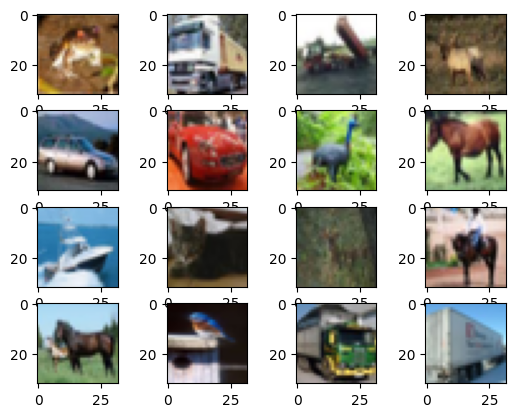

In [4]:
for i in range(16):
    # define subplot
    plt.subplot(4, 4, 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i])
plt.show()

Examine the training dataset

In [5]:
print(train_data.data.shape)
print(train_data.class_to_idx)

(50000, 32, 32, 3)
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Data Transforms

In [6]:
train_data_path = "./train"
train_transform = transforms.Compose([
    transforms.Resize((64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.201))])

test_data_path = "./test"
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.201))])

training_data = CIFAR10(train_data_path, train=True, download=True, transform=train_transform)
test_data = CIFAR10(test_data_path, train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


Data batching

In [7]:
from torch.utils.data import DataLoader, random_split
batch_size = 64
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Model Development and Training**

In [8]:
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

Basic AlexNet

AlexNet is the name of the convolutional neural network (CNN) designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton at the university of Toronto, the CNN competed in the imagenet challenge on September 30, 2012.

The network influential nature came from it’s use of GPU to accelerate deep learning, even though it was not the first to do so nonetheless the AlexNet paper was cited over 80,00 times influencing many other papers and research into using GPUs to accelerate deep learning.



In [9]:
NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x



Instantiate the Model

In [10]:
# define the loss function and optimizer
net = AlexNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Pick a manual seed for randomization
torch.manual_seed(41)

Load and transform the data

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Train the network

Epoch 1, Training Loss: 2.2672916593551635, Validation Loss: 2.036131928680809, Validation Accuracy: 20.4
Epoch 2, Training Loss: 1.8120054195404052, Validation Loss: 1.6176783977800113, Validation Accuracy: 35.12
Epoch 3, Training Loss: 1.5172675992965698, Validation Loss: 1.3633576274677446, Validation Accuracy: 48.7
Epoch 4, Training Loss: 1.269468371486664, Validation Loss: 1.217279742857453, Validation Accuracy: 55.6
Epoch 5, Training Loss: 1.0880352310180663, Validation Loss: 1.0470340043116526, Validation Accuracy: 62.4
Epoch 6, Training Loss: 0.9550695559501649, Validation Loss: 0.9648064173710574, Validation Accuracy: 65.89
Epoch 7, Training Loss: 0.8397254244804382, Validation Loss: 0.8620384411447367, Validation Accuracy: 69.57
Epoch 8, Training Loss: 0.7247897486209869, Validation Loss: 0.9092997134111489, Validation Accuracy: 69.34
Epoch 9, Training Loss: 0.630920116686821, Validation Loss: 0.8535713583800444, Validation Accuracy: 71.84
Epoch 10, Training Loss: 0.540842844

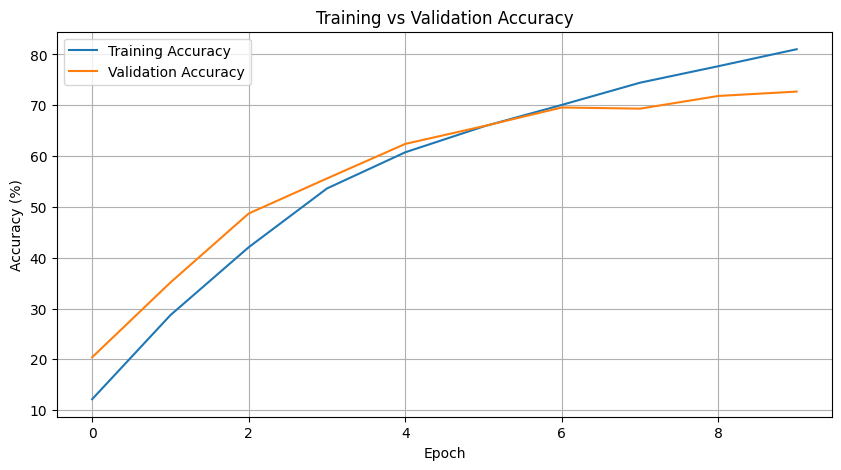

In [12]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy
train_accuracies = []
val_accuracies = []

num_of_epochs = 10
for epoch in range(num_of_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training accuracy for the current epoch
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation accuracy for the current epoch
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print statistics for each epoch
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {val_loss / len(testloader)}, Validation Accuracy: {val_accuracy}')

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


From the plot, the results are as follows:

**Training Accuracy (Blue Line)**:

The training accuracy steadily increases over the epochs, indicating that the model is learning from the training data.
There are no sharp jumps or drops, which suggests that the training process is relatively stable.It still climbs towards the end of the plot, meaning the model may still improve with more training epochs.

**Validation Accuracy (Orange Line)**:

The validation accuracy is higher than the training accuracy in the early epochs, which suggests that the model is generalizing well to the validation data initially. This could be because the model is not yet complex enough to overfit the training data.
The validation accuracy reaches a plateau at around epoch 6, with only slight improvement after that. It appears to converge to around 73%.
This plateau suggests that the model may need further tuning or adjustments (such as more training epochs, a deeper network, or more advanced regularization) to push the validation accuracy higher.





**2.0 Experiment with Underfitting and Overfitting**

For the purposes of underfitting, The following are being reduced
1. Two Convolutional layers
2. Input size
3. Number of filters

In [13]:
class AlexNet_Underfit(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_Underfit, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Reduced filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Reduced filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Reduced filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 2 * 2, 512),  # Reduced neurons
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 2 * 2)
        x = self.classifier(x)
        return x


In [14]:
# define the loss function and optimizer
net = AlexNet_Underfit()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Pick a manual seed for randomization
torch.manual_seed(41)

Epoch 1, Training Loss: 1.9089946468353272, Validation Loss: 1.5568648090787753, Validation Accuracy: 42.18
Epoch 2, Training Loss: 1.4716965770721435, Validation Loss: 1.3094891013613172, Validation Accuracy: 52.53
Epoch 3, Training Loss: 1.3087476980209352, Validation Loss: 1.1763986075759694, Validation Accuracy: 57.21
Epoch 4, Training Loss: 1.182365937423706, Validation Loss: 1.066812506906546, Validation Accuracy: 61.85
Epoch 5, Training Loss: 1.0882138467788696, Validation Loss: 1.0496040468762635, Validation Accuracy: 62.79
Epoch 6, Training Loss: 1.016486768913269, Validation Loss: 0.9783300578973855, Validation Accuracy: 65.46
Epoch 7, Training Loss: 0.9472374205589295, Validation Loss: 0.9315263788411572, Validation Accuracy: 67.58
Epoch 8, Training Loss: 0.8967118833541871, Validation Loss: 0.8866848434991897, Validation Accuracy: 69.02
Epoch 9, Training Loss: 0.8577735615730285, Validation Loss: 0.8705501818353203, Validation Accuracy: 69.38
Epoch 10, Training Loss: 0.8206

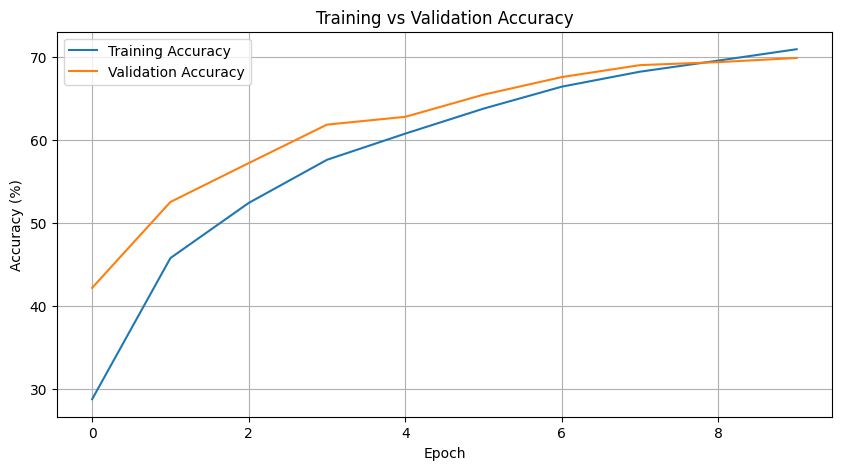

In [15]:
# Initialize lists to store loss and accuracy
train_accuracies = []
val_accuracies = []

for epoch in range(num_of_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training accuracy for the current epoch
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation accuracy for the current epoch
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print statistics for each epoch
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {val_loss / len(testloader)}, Validation Accuracy: {val_accuracy}')

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


In [16]:
class AlexNet_Overfit(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_Overfit, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),  # Increased filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Increased filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Increased filters
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Increased filters
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  # Added layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 8192),  # Increased neurons
            nn.ReLU(inplace=True),
            nn.Linear(8192, 8192),  # Increased neurons
            nn.ReLU(inplace=True),
            nn.Linear(8192, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 1024 * 2 * 2)  # Adjust for the increased filters
        x = self.classifier(x)
        return x


In [17]:
# define the loss function and optimizer
net = AlexNet_Overfit()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Pick a manual seed for randomization
torch.manual_seed(41)

Epoch 1, Training Loss: 2.1053307773590086, Validation Loss: 1.6850955820387337, Validation Accuracy: 36.19
Epoch 2, Training Loss: 1.5459843700408935, Validation Loss: 1.4328566683325799, Validation Accuracy: 45.53
Epoch 3, Training Loss: 1.2604163749694823, Validation Loss: 1.1814265832020219, Validation Accuracy: 57.32
Epoch 4, Training Loss: 1.066433911037445, Validation Loss: 1.0068395741426261, Validation Accuracy: 63.41
Epoch 5, Training Loss: 0.9085798361778259, Validation Loss: 0.9805308014723906, Validation Accuracy: 65.4
Epoch 6, Training Loss: 0.7744842865943908, Validation Loss: 0.9895067674339197, Validation Accuracy: 66.59
Epoch 7, Training Loss: 0.6530301015377045, Validation Loss: 0.8205133298779749, Validation Accuracy: 71.22
Epoch 8, Training Loss: 0.5445647684335708, Validation Loss: 0.8460043653561051, Validation Accuracy: 72.13
Epoch 9, Training Loss: 0.445981388425827, Validation Loss: 0.8514804990048621, Validation Accuracy: 71.9
Epoch 10, Training Loss: 0.34552

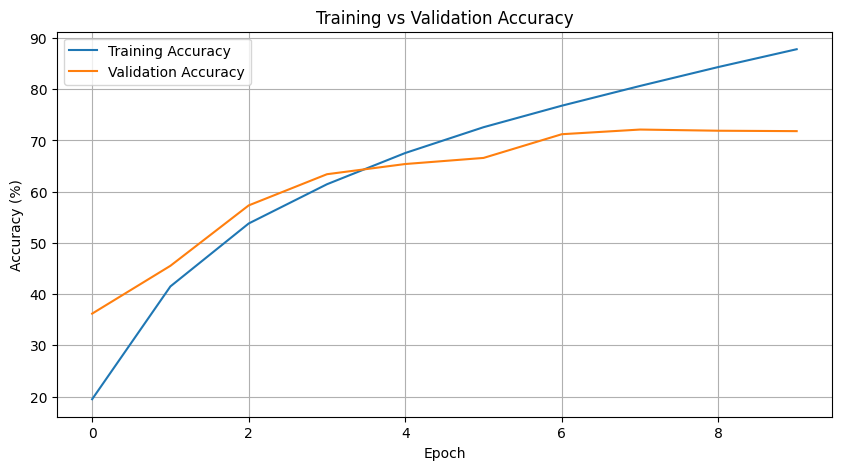

In [18]:
# Initialize lists to store loss and accuracy
train_accuracies = []
val_accuracies = []

for epoch in range(num_of_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training accuracy for the current epoch
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation accuracy for the current epoch
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print statistics for each epoch
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {val_loss / len(testloader)}, Validation Accuracy: {val_accuracy}')

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 2.008, Training Accuracy: 21.69%
Validation Accuracy after Epoch 1: 35.11%
Epoch 2, Loss: 1.559, Training Accuracy: 40.09%
Validation Accuracy after Epoch 2: 50.92%
Epoch 3, Loss: 1.238, Training Accuracy: 55.21%
Validation Accuracy after Epoch 3: 62.69%
Epoch 4, Loss: 0.999, Training Accuracy: 64.60%
Validation Accuracy after Epoch 4: 64.87%
Epoch 5, Loss: 0.836, Training Accuracy: 70.64%
Validation Accuracy after Epoch 5: 71.22%
Epoch 6, Loss: 0.711, Training Accuracy: 75.76%
Validation Accuracy after Epoch 6: 75.02%
Epoch 7, Loss: 0.608, Training Accuracy: 79.53%
Validation Accuracy after Epoch 7: 75.78%
Epoch 8, Loss: 0.512, Training Accuracy: 82.74%
Validation Accuracy after Epoch 8: 76.86%
Epoch 9, Loss: 0.433, Training Accuracy: 85.58%
Validation Accuracy after Epoch 9: 78.43%
Epoch 10, Loss: 0.375, Training Accuracy: 87.48%
Validation Accuracy after Epoch 10: 76.25%


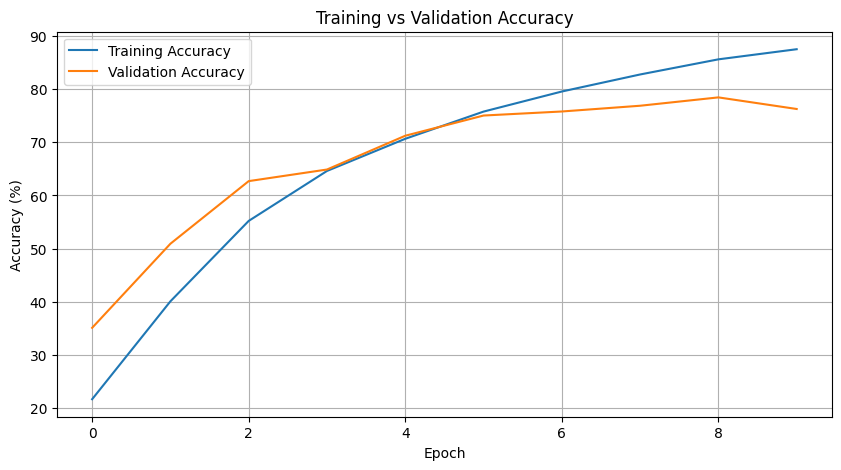

In [19]:
# Load VGG16 model and modify the final layer for CIFAR-10 (10 classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, 10)  # Adjust for CIFAR-10
vgg16 = vgg16.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training and evaluation lists to plot accuracy later
train_accuracies = []
val_accuracies = []


for epoch in range(num_of_epochs):
    vgg16.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = vgg16(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}, Training Accuracy: {train_acc:.2f}%')

    # Validation loop
    vgg16.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    val_accuracies.append(val_acc)
    print(f'Validation Accuracy after Epoch {epoch+1}: {val_acc:.2f}%')

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()
